# This notebook includes following steps in order to get data for my Project:

* Create Database with sqlite3. Create tables in DB
* Get information about each business Using API requests to www.yelp.com and load it into DB
* Scrape reviews about each business using BeautifulSoup and load it into DB
* Define clear target variable for future modeling
* Create corpus from the data and save it for next steps in this project

In [26]:
import numpy as np
import sqlite3
import requests
import json
import pandas as pd
from  keys  import  client_id, api_key
from bs4 import BeautifulSoup
import folium
import time
import random
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns; sns.set()

from utils import * # import all existing functions from file utils.py

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Create Database with sqlite3. Create tables in DB

In [19]:
# Creating a new DB and setting up cursor to it
conn = sqlite3.connect('../data/business_places.db')
cursor = conn.cursor()

In [8]:
# Creating dictionary where each key represents table name in DB and value represents query with Create statement with columns

TABLES = {}

TABLES['business'] = (
    
    """CREATE TABLE business (
        business_id VARCHAR(30) NOT NULL,
        alias TEXT,
        name TEXT,
        url TEXT,
        phone TEXT,
        
        review_count INTEGER,
        rating DECIMAL,
    
        address TEXT,
        city TEXT,
        zip_code INTEGER NOT NULL,
        country TEXT,
        state TEXT,
        
        coordinate_latitude DECIMAL,
        coordinate_longtitude DECIMAL,
        
        price TEXT,
      
        PRIMARY KEY (business_id)
        );
    """)

TABLES['reviews'] = (
    
    """CREATE TABLE reviews (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        name TEXT,
        location TEXT,
        rating TEXT,
        date TEXT,
        business_id VARCHAR(30),
        text TEXT,
        FOREIGN KEY (business_id)
            REFERENCES business (business_id)
        
        );
    """)

In [9]:
# Itareting trough dict TABLES and executing query incoded into value of the each dict.
for table_name in TABLES:
    table_description = TABLES[table_name]
    cursor.execute('DROP TABLE IF EXISTS {};'.format(table_name))
    cursor.execute(table_description)

In [10]:
# Setting UP variables which will be using for API request to yelp web 

url =  'https://api.yelp.com/v3/businesses/search'
headers = {'Authorization': 'Bearer {}'.format(api_key)}
term = 'Coffee Shop'
locations = ['Brooklyn', 'Queens', 'Manhattan']
categories = 'Coffee & tea'
price = [1,2,3,4]
limit = 50
cur = 0

In [11]:
url_params = {
                "term": term.replace(' ', '+'),
                "location": locations,
                "categories" : categories,
                "price" : price,
                "limit" : limit,
                "offset" : cur
                
            }

In [12]:
def yelp_call(url_params, api_key):
    """
    Sending API request.
    Returns data represented as list of dict.
    Each dict contain information about 1 buisness
    Params : url_params - dict
             api_key - unique key access to web
    
    """
    response = requests.get(url=url, headers=headers, params=url_params)
    data = json.loads(response.text)
    try:
        return data['businesses']
    except:
        print(data)
        return data

In [13]:
def parse_results(list_of_data):
    """
    parsing data by the keys.
    params : list_of_data - list of dict (each dict repr. 1 buisness)
    return : list of tuples with 10 elements in each
    """
    parsed_results = []
    for business in list_of_data:
        #if int(business['location']['zip_code']) in zip_queens+zip_bklyn: # only takes bus located in Bklyn or Queens 
        bus_tup = (business['id'],
                    business['alias'],
                    business['name'],
                    business['url'],
                    business['phone'],                   
                    business['review_count'],
                    business['rating'],
                    ','.join(business['location']['display_address']),
                    business['location']['city'],
                    business['location']['country'],
                    business['location']['state'],
                    int(business['location']['zip_code']),
                    business['price'],
                    business['coordinates']['latitude'],
                    business['coordinates']['longitude']
                    )
        parsed_results.append(bus_tup)

    return parsed_results

In [14]:
def db_insert(cursor, parsed_results):
    """
    Inserting data into DB
    Params : cursor
             parsed_results - list of tuplease
    """
    
    insert_statement = '''INSERT INTO business (
        business_id,
        alias,
        name,
        url,
        phone,
        review_count,
        rating,
        address,
        city,
        country,
        state,
        zip_code,
        price,
        coordinate_latitude,
        coordinate_longtitude) VALUES ( ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ? )'''

    cursor.executemany(insert_statement, parsed_results)

## Get information about each business Using API requests to www.yelp.com and load it into DB

In [15]:
# Looping trough list of Location that we need to get data about
# sending each location to yelp as API reques
# getting back data then sending it to parce and collect it to all_results list
# callinf function db_insert to record parced data into table Buisness in DB

all_results =[]
for location in tqdm(locations):
    url_params['location'] = location
    for cur in range(0,1000,50):
        url_params['offset'] = cur
        results = yelp_call(url_params, api_key)
        parsed_results = parse_results(results)
        all_results.extend(parsed_results)
        
db_insert(cursor, list(set(all_results)))

100%|██████████| 3/3 [01:00<00:00, 20.05s/it]


In [16]:
# Retriving business_id from DB Table business and collecting into list 
business_ids = [t[0] for t in cursor.execute("""SELECT business_id FROM business;""").fetchall()]

In [17]:
len(business_ids)

1653

In [46]:
# Lets Look at all businesses in DB

dfb = pd.DataFrame(cursor.execute("SELECT * FROM business").fetchall())
dfb.columns = [x[0] for x in cursor.description]
dfb

,business_id,alias,name,url,phone,review_count,rating,address,city,zip_code,country,state,coordinate_latitude,coordinate_longtitude,price
0,KvLrI20Abz6F9WzAIHmyWQ,cafe-r-new-york,Cafe R,https://www.yelp.com/biz/cafe-r-new-york?adjus...,+12126959550,277,3.0,"116 W 32nd St,New York, NY 10001",New York,10001,US,NY,40.748830,-73.989720,$
1,atFUpFBD3QKUxjXzSaWbmQ,margot-patisserie-new-york,Margot Patisserie,https://www.yelp.com/biz/margot-patisserie-new...,+12127210076,115,3.5,"2109 Broadway W74th St,New York, NY 10023",New York,10023,US,NY,40.780075,-73.982247,$$
2,TF_pSzZv3wVLIGArUERkbw,pennylane-coffee-new-york-2,Pennylane Coffee,https://www.yelp.com/biz/pennylane-coffee-new-...,+19177975133,147,4.0,"305 E 45th St,New York, NY 10017",New York,10017,US,NY,40.751770,-73.969924,$$
3,BvUFZSvxIh4gCY_TKFhnIw,joe-and-the-juice-new-york-40,JOE & THE JUICE,https://www.yelp.com/biz/joe-and-the-juice-new...,,20,4.0,"1400 Madison Ave,New York, NY 10029",New York,10029,US,NY,40.788150,-73.953680,$$
4,uks5xzzN5F88a3OOibkYLg,jill-lindsey-brooklyn,Jill Lindsey,https://www.yelp.com/biz/jill-lindsey-brooklyn...,+13479874538,25,4.0,"370 Myrtle Ave,Brooklyn, NY 11205",Brooklyn,11205,US,NY,40.692973,-73.971356,$$$
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1648,ml5hBBDsEILy9WsTQyyV-Q,b-cup-café-new-york-5,B Cup Café,https://www.yelp.com/biz/b-cup-caf%C3%A9-new-y...,+12122284808,377,4.0,"212 Ave B,New York, NY 10009",New York,10009,US,NY,40.728708,-73.978827,$
1649,nyqK-hAA8ZKYar9PuQiBiA,bakeri-brooklyn-2,Bakeri,https://www.yelp.com/biz/bakeri-brooklyn-2?adj...,+17183491542,95,4.0,"105 Freeman St,Brooklyn, NY 11222",Brooklyn,11222,US,NY,40.734310,-73.957530,$$
1650,ipygjHXH9PqQS6aqU54RcQ,partners-coffee-brooklyn,Partners Coffee,https://www.yelp.com/biz/partners-coffee-brook...,+13475860063,479,4.0,"125 N 6th St,Brooklyn, NY 11249",Brooklyn,11249,US,NY,40.717960,-73.959210,$$
1651,JtFmorYKrCMAteQINECi7g,the-french-market-rumson,The French Market,https://www.yelp.com/biz/the-french-market-rum...,+17325301692,48,4.0,"114 E River Rd,Rumson, NJ 07760",Rumson,7760,US,NJ,40.373530,-74.000490,$$


In [47]:
# saving to csv file
# dfb.to_csv('../data/business.csv')

# Lets Create a map, where each marker represents a business with corresponding name and adress 

In [20]:
# Creating map of Brooklyn-Queens where each poin represents buisness location

bq_coordinates =[(40.6501+40.68149)/2,(-73.94958-73.83652)/2]
business_data = dfb[['coordinate_latitude','coordinate_longtitude','name','address']].values

def map_from(location, zoom_amount):
    map_ =folium.Map(location=location, zoom_start=zoom_amount)
    return map_

def add_business_mark(bus_markers_list, map_obj):
    for marker in bus_markers_list:
        marker.add_to(map_obj)
    return map_obj

bq_map = map_from(bq_coordinates, 11)
bus_markers_list = [ folium.Circle([lat,long], radius=10, tooltip=name, popup='<i>{}</i>'.format(add)) for lat,long,name,add in business_data ]

add_business_mark(bus_markers_list, bq_map)

## Scrape reviews about each business using BeautifulSoup and load it into DB

Using Information about each buisness including Yelp url we can webscrape reviews about each buisness.

In [21]:
def get_review_info(x, business_id):
    """
    x - bs4.element.Tag
    """
    review_info = {}
    review_info['name'] = x.find(class_ = 'css-166la90').text
    review_info['location'] = x.find(class_ = 'css-n6i4z7').text
    review_info['rating'] = x.find(class_ = 'i-stars__373c0__1BRrc')['aria-label']
    review_info['date'] = x.find(class_ = 'css-e81eai').text
    review_info['business_id']= business_id
    review_info['text']= x.find(class_ = 'raw__373c0__3rcx7').text
    
    return review_info

In [22]:
def get_business_reviews(url, business_id):
    
    page = requests.get(url, timeout=7)
    soup = BeautifulSoup(page.content, 'html.parser')
    x = soup.findAll(class_='margin-b5__373c0__2ErL8')
    
    reviews = []
    
    if len(x) == 21:
        for i in range(1,21):
            review = get_review_info(soup.findAll(class_='margin-b5__373c0__2ErL8')[i], business_id)
            reviews.append(review)

    if len(x) == 22:
        for i in range(2,22):
            review = get_review_info(soup.findAll(class_='margin-b5__373c0__2ErL8')[i], business_id)
            reviews.append(review)
        
    else: pass
    
    return reviews

In [23]:
def parse_review(review_respond):
    """
    parsing data by the keys.
    params : review_respond - dict
             business_id - string
    return : list of tuples with 6 elements in each
    """
    parsed_results = []
    
    for review in review_respond:
        parsed_results.append((
            review['name'],
            review['location'],
            review['rating'],
            review['date'],
            review['business_id'],
            review['text'],
        ))

    return parsed_results

In [24]:
def db_insert_reviews(cursor, reviews_list):
    """
    Inserting data into DB
    Params : cursor
             reviews_list - list of tuples
    """
    
    insert_statement = '''INSERT INTO reviews (
        name,
        location,
        rating,
        date,
        business_id,
        text) VALUES ( ?, ?, ?, ?, ?, ? )'''

    cursor.executemany(insert_statement, reviews_list)

* Iterating trough each business url and business_id 
* Scraping reviews from each business yelp page
* parsing reviews and loading in Data Base
* setting random time sleeep in order do not get blocked

In [25]:
broken_urls =[]

In [39]:
for i,business in tqdm(dfb[['url','business_id']].iterrows()):
    try:
        #print("Current date & time " + time.strftime("%c"))
        reviews = get_business_reviews(business[0],business[1])
        parsed_reviews = parse_review(review_respond= reviews)
        db_insert_reviews(cursor = cursor, reviews_list = parsed_reviews)
        time.sleep(random.choice([x/10 for x in range(4,10)]))
        
    except:
        
        broken_urls.append((i,business[0],business[1]))
        print('Error in {}'.format(business[0]))

169it [15:27,  6.40s/it]

Error in https://www.yelp.com/biz/dr-smood-soho-new-york-3?adjust_creative=XCA5Kc7RlIdeGhJ7qoZSYA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=XCA5Kc7RlIdeGhJ7qoZSYA


203it [18:38,  5.91s/it]

Error in https://www.yelp.com/biz/irving-farm-new-york-new-york-10?adjust_creative=XCA5Kc7RlIdeGhJ7qoZSYA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=XCA5Kc7RlIdeGhJ7qoZSYA


208it [19:07,  6.12s/it]

Error in https://www.yelp.com/biz/levain-bakery-new-york-5?adjust_creative=XCA5Kc7RlIdeGhJ7qoZSYA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=XCA5Kc7RlIdeGhJ7qoZSYA


276it [25:25,  5.83s/it]

Error in https://www.yelp.com/biz/hudson-coffee-company-hoboken?adjust_creative=XCA5Kc7RlIdeGhJ7qoZSYA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=XCA5Kc7RlIdeGhJ7qoZSYA


585it [53:04,  5.96s/it]

Error in https://www.yelp.com/biz/las-cubanitas-bake-shop-union-city?adjust_creative=XCA5Kc7RlIdeGhJ7qoZSYA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=XCA5Kc7RlIdeGhJ7qoZSYA


605it [55:01,  6.19s/it]

Error in https://www.yelp.com/biz/charley-st-new-york?adjust_creative=XCA5Kc7RlIdeGhJ7qoZSYA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=XCA5Kc7RlIdeGhJ7qoZSYA


1653it [1:33:03,  3.38s/it]


In [40]:
len(broken_urls)

6

In [48]:
dfr = pd.DataFrame(cursor.execute("SELECT * FROM reviews").fetchall())
dfr.columns = [x[0] for x in cursor.description]
dfr

,id,name,location,rating,date,business_id,text
0,121,Alan H.,"Tampa, FL",3 star rating,3/2/2020,KvLrI20Abz6F9WzAIHmyWQ,With Cafe R and the hotel having a deal for us...
1,122,Shraddha R.,"New York, NY",2 star rating,5/4/2019,KvLrI20Abz6F9WzAIHmyWQ,Went here because we had a food coupon we didn...
2,123,Michelle L.,"Washington Heights, Manhattan, NY",1 star rating,7/21/2020,KvLrI20Abz6F9WzAIHmyWQ,As you guys are aware majority of places are c...
3,124,Paul L.,"North Babylon, NY",1 star rating,1/26/2020,KvLrI20Abz6F9WzAIHmyWQ,Went here fo continental breakfast and this pl...
4,125,Andrew G.,"Manhattan, NY",4 star rating,11/27/2019,KvLrI20Abz6F9WzAIHmyWQ,Great cafe located in a busy section of Chelse...
...,...,...,...,...,...,...,...
13435,13556,Sam J.,"Mahwah, NJ",5 star rating,6/20/2020,yumsgnyR7ujrQP-H59eG4g,Stray Cat was an awesome find! It's insane how...
13436,13557,Julianne D.,"Strasbourg-St Denis/Bonne Nouvelle, Paris, France",1 star rating,8/29/2020,yumsgnyR7ujrQP-H59eG4g,Disappointed with my first visit at the stray ...
13437,13558,Brendalynne F.,"Parsippany, NJ",5 star rating,9/17/2018,yumsgnyR7ujrQP-H59eG4g,Stray Cat Brew's S'mores Frozen Hot Chocolate ...
13438,13559,Cheryl H.,"Cliffside Park, NJ",4 star rating,9/19/2020,yumsgnyR7ujrQP-H59eG4g,This was my first visit and was with the littl...


In [44]:
# dfr.to_csv('../data/reviews.csv')

5 star rating    7048
4 star rating    3502
3 star rating    1267
1 star rating     937
2 star rating     686
Name: rating, dtype: int64




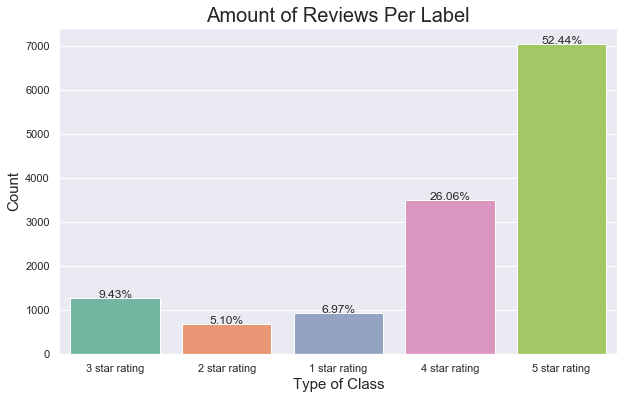

In [88]:
print(dfr['rating'].value_counts())

print('\n')
# Class Imbalance 

fig, ax = plt.subplots(figsize=(10,6))
ax = sns.countplot(dfr['rating'], palette='Set2')

ax.set_title('Amount of Reviews Per Label',fontsize = 20)
ax.set_xlabel('Type of Class',fontsize = 15)
ax.set_ylabel('Count',fontsize = 15)
# ax.set_xticklabels(['1 star', '2 star', '3 star', '4 star', '5 star'],fontsize = 13)

total = float(len(dfr)) # one person per row 
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total * 100) + '%',
            ha="center")

#### As we can see from visualization - majority of reviews belongs to class with 5 stars
#### It happened because scraping was made from business yelp pages with yelp sorting criterious 
#### Lets try to scrape data and specify sorting order of reviews from lovest to highest

In [49]:
def get_business_reviews_rating_asc(url, business_id):
    
    page = requests.get(url+'&sort_by=rating_asc', timeout=7)
    soup = BeautifulSoup(page.content, 'html.parser')
    x = soup.findAll(class_='margin-b5__373c0__2ErL8')
    
    reviews = []
    
    if len(x) == 21:
        for i in range(1,21):
            review = get_review_info(soup.findAll(class_='margin-b5__373c0__2ErL8')[i], business_id)
            reviews.append(review)

    if len(x) == 22:
        for i in range(2,22):
            review = get_review_info(soup.findAll(class_='margin-b5__373c0__2ErL8')[i], business_id)
            reviews.append(review)
        
    else: pass
    
    return reviews

* Iterating trough each business url and business_id 
* Scraping reviews from each business yelp page
* parsing reviews and loading in Data Base
* setting random time sleeep in order do not get blocked

In [52]:
broken_urls_asc = []

In [69]:
for i,business in tqdm(dfb[['url','business_id']].iterrows()):
    try:
        #print("Current date & time " + time.strftime("%c"))
        reviews = get_business_reviews(business[0],business[1])
        parsed_reviews = parse_review(review_respond= reviews)
        db_insert_reviews(cursor = cursor, reviews_list = parsed_reviews)
        time.sleep(random.choice([x/10 for x in range(4,10)]))
        
    except:
        broken_urls.append((i,business[0],business[1]))
        print('error in {}'.format(business))

In [70]:
dfr_asc = pd.DataFrame(cursor.execute("SELECT * FROM reviews_rating_asc").fetchall())
dfr_asc.columns = [x[0] for x in cursor.description]
dfr_asc = dfr_asc.drop(columns = ['index', 'Unnamed: 0'])
dfr_asc

,id,name,location,rating,date,business_id,text
0,401,Hannah L.,"Denver, CO",1 star rating,2/20/2020,1NDrUD3rct843ekECS9Dkw,I ordered the quesadilla. It came to the table...
1,402,Amy H.,"Mount Sinai, NY",1 star rating,2/16/2020,1NDrUD3rct843ekECS9Dkw,Rude and slow service. Food over priced and no...
2,403,Sophia S.,"Saddle River, NJ",1 star rating,2/15/2020,1NDrUD3rct843ekECS9Dkw,I went to Cafe Lalo with a friend for Valentin...
3,404,Jennise C.,"Houston, TX",1 star rating,12/25/2019,1NDrUD3rct843ekECS9Dkw,I worst experience while in New York. Slow ser...
4,405,V L.,"Manhattan, NY",1 star rating,12/11/2019,1NDrUD3rct843ekECS9Dkw,BEWARE!! You will pay triple what it is worth ...
...,...,...,...,...,...,...,...
27775,28176,Jesseca R.,"Queens, NY",4 star rating,7/5/2018,iF1wqaFU-JgElX1lCGda6A,Really love the coffee (but warning: it's supe...
27776,28177,Robert W.,"Queens, Queens, NY",4 star rating,3/11/2018,iF1wqaFU-JgElX1lCGda6A,"Not familiar with the neighborhood, I discover..."
27777,28178,Lexie M.,"Baltimore, MD",4 star rating,1/6/2018,iF1wqaFU-JgElX1lCGda6A,Cute little spot with great indoor and even be...
27778,28179,L P.,"Manhattan, NY",4 star rating,6/24/2017,iF1wqaFU-JgElX1lCGda6A,I spent 6 days in Ridgewood while filming a ne...


In [68]:
# dfr_asc.to_csv('../data/reviews_rating_asc.csv')

1 star rating    13342
2 star rating     5040
3 star rating     3726
4 star rating     3602
5 star rating     2070
Name: rating, dtype: int64




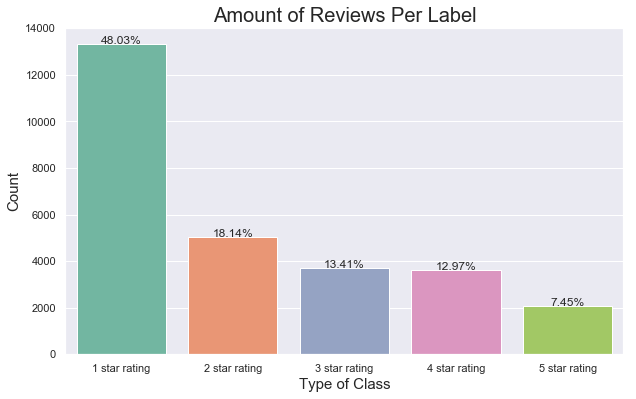

In [87]:
print(dfr_asc['rating'].value_counts())

print('\n')
# Class Imbalance 

fig, ax = plt.subplots(figsize=(10,6))
ax = sns.countplot(dfr_asc['rating'], palette='Set2')

ax.set_title('Amount of Reviews Per Label',fontsize = 20)
ax.set_xlabel('Type of Class',fontsize = 15)
ax.set_ylabel('Count',fontsize = 15)
# ax.set_xticklabels(['1 star', '2 star', '3 star', '4 star', '5 star'],fontsize = 13)


total = float(len(dfr_asc)) # one person per row 
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total * 100) + '%',
            ha="center")

## Combining Dataframes in order to get final CORPUS and Defining Target Variable

In [32]:
df = pd.concat([dfr, dfr_asc])

In [33]:
df = df.drop(columns='id')

In [34]:
df = df.drop_duplicates()

In [35]:
df.head()

,name,location,rating,date,business_id,text,Unnamed: 0
0,Alan H.,"Tampa, FL",3 star rating,3/2/2020,KvLrI20Abz6F9WzAIHmyWQ,With Cafe R and the hotel having a deal for us...,NaN
1,Shraddha R.,"New York, NY",2 star rating,5/4/2019,KvLrI20Abz6F9WzAIHmyWQ,Went here because we had a food coupon we didn...,NaN
2,Michelle L.,"Washington Heights, Manhattan, NY",1 star rating,7/21/2020,KvLrI20Abz6F9WzAIHmyWQ,As you guys are aware majority of places are c...,NaN
3,Paul L.,"North Babylon, NY",1 star rating,1/26/2020,KvLrI20Abz6F9WzAIHmyWQ,Went here fo continental breakfast and this pl...,NaN
4,Andrew G.,"Manhattan, NY",4 star rating,11/27/2019,KvLrI20Abz6F9WzAIHmyWQ,Great cafe located in a busy section of Chelse...,NaN


1 star rating    14279
5 star rating     9118
4 star rating     7104
2 star rating     5726
3 star rating     4993
Name: rating, dtype: int64




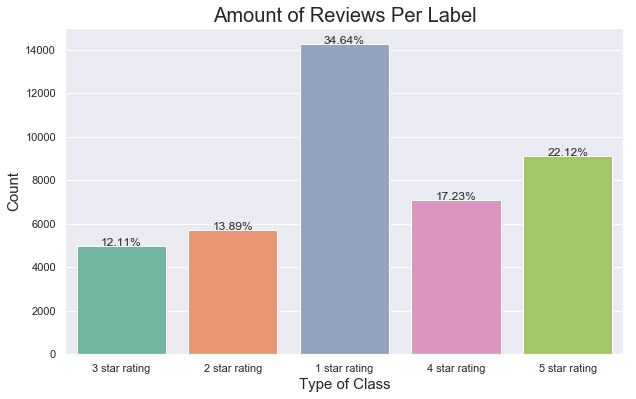

In [43]:
print(df['rating'].value_counts())

print('\n')

# Class Imbalance 

fig, ax = plt.subplots(figsize=(10,6))
ax = sns.countplot(df['rating'], palette='Set2')

ax.set_title('Amount of Reviews Per Label',fontsize = 20)
ax.set_xlabel('Type of Class',fontsize = 15)
ax.set_ylabel('Count',fontsize = 15)
# ax.set_xticklabels(['1 star', '2 star', '3 star', '4 star', '5 star'],fontsize = 13)

total = float(len(df))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total * 100) + '%',
            ha="center")
    
plt.savefig(fname='../images/5_class', bbox_inches='tight', pad_inches=.1)

In [39]:
corpus = df.copy()

In [40]:
corpus['rating'] = corpus['rating'].map(lambda x: target_mod(x))

Negative    20005
Positive    16222
Neutral      4993
Name: rating, dtype: int64




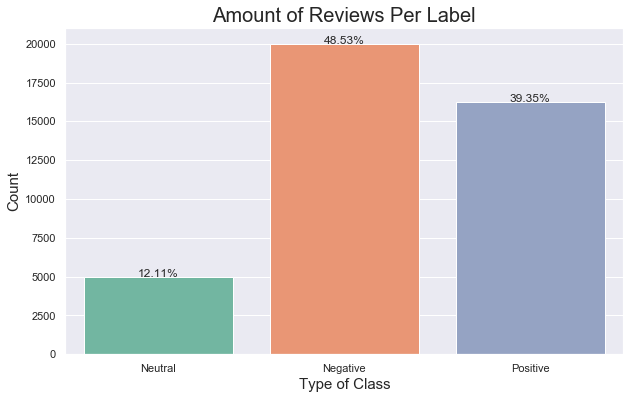

In [44]:
print(corpus['rating'].value_counts())

print('\n')

# Class Imbalance 

fig, ax = plt.subplots(figsize=(10,6))
ax = sns.countplot(corpus['rating'], palette='Set2')

ax.set_title('Amount of Reviews Per Label',fontsize = 20)
ax.set_xlabel('Type of Class',fontsize = 15)
ax.set_ylabel('Count',fontsize = 15)
# ax.set_xticklabels(['1 star', '2 star', '3 star', '4 star', '5 star'],fontsize = 13)

total = float(len(df))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total * 100) + '%',
            ha="center")
    
plt.savefig(fname='../images/3_class', bbox_inches='tight', pad_inches=.1)

In [100]:
# Saving Corpus to DB and csv

In [20]:
df.to_csv('../data/corpus.csv')

In [22]:
cursor.execute('DROP TABLE IF EXISTS corpus')

In [23]:
df.to_sql('corpus', con= conn)

In [24]:
cursor.close()
conn.close()